# Honors Thesis
## An Exploratory Study of Biometric Gait Recognition
## Compiled by David Kartchner
## November 30, 2016

In [8]:
import numpy as np
import pandas as pd
from __future__ import division
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
import matplotlib
import pywt
from scipy.fftpack import fft, ifft
from scipy.interpolate import interp1d
import seaborn as sns
from scipy import stats
from biometric_helper import *
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (14.0, 7.0)
pd.set_option('expand_frame_repr', True)
pd.set_option('max_rows',200)

In [2]:
accel_data = clean_data(pd.read_csv('ProjectData.csv'))

biometric_helper.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  group["Samplerate"] = 50


In [3]:
print accel_data.shape

(921037, 3)


In [4]:
data = feature_extraction(accel_data, split_var="JointID")
print "Features Created"

Features Created


/Users/davidspencerkartchner/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [6]:
train, test = template_split(data, label_col="Label")
train_l = train.Label
train_f = train.drop("Label",1)
test_l = train.Label
test_f = train.drop("Label",1)

biometric_helper.py:482: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  test_rows = np.random.choice(num_rows, size=np.floor(.3*num_rows), replace=False)


In [7]:
train_f.describe()

,Mean,Std,Max,Min,Range,RMS,FDE,0,1,2,3,4,5,6,7,8,9,Sign
count,4302.000000,4302.000000,4302.000000,4302.000000,4302.000000,4302.000000,4302.000000,4302.000000,4302.000000,4302.000000,4302.000000,4302.000000,4302.000000,4302.000000,4302.000000,4302.000000,4302.000000,4302.000000
mean,1298.449027,464.197738,3057.321916,497.679210,2559.642706,1394.013737,0.727144,14.228498,22.913529,30.245932,29.637378,20.207345,12.818457,8.173408,5.411669,3.376569,2.987215,25.836355
std,286.979464,290.342413,1442.916994,274.688578,1608.723383,350.460364,0.479049,10.921848,14.323770,15.690314,14.666662,12.227585,10.865255,8.405784,6.373224,4.234686,2.301213,8.998085
min,943.385818,17.380662,1080.251012,30.028112,94.328383,956.318347,0.003428,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000
25%,1092.514067,233.311530,1858.232758,276.265098,1177.064549,1122.491556,0.249801,6.000000,11.250000,19.000000,20.000000,12.000000,4.000000,2.000000,1.000000,1.000000,1.000000,18.000000
50%,1216.039486,435.901900,2739.701063,412.554239,2323.071551,1317.347705,0.750817,13.000000,22.000000,29.000000,29.000000,18.000000,10.000000,5.000000,3.000000,2.000000,2.000000,26.000000
75%,1446.210511,685.227454,4177.994027,728.675607,3903.012372,1597.093535,1.152309,20.000000,32.000000,39.000000,37.000000,26.000000,19.000000,12.000000,8.000000,4.000000,4.000000,32.000000
max,5455.561389,3984.589213,16542.006081,1456.025626,16291.901478,6747.907448,2.433653,122.000000,119.000000,121.000000,135.000000,122.000000,107.000000,70.000000,41.000000,36.000000,20.000000,60.000000


          Mean         Std          Max         Min        Range          RMS  \
0  1056.483855   43.359668  1239.829953  948.862905   290.967048  1057.367326   
1  1052.896251   79.452031  1217.827497  835.352508   382.474989  1055.869810   
4  1058.959304   26.887931  1154.158026  999.485430   154.672596  1059.298328   
6  1078.336475   94.646602  1404.977246  825.952253   579.024993  1082.454531   
7  1110.473550  290.721716  2494.599542  417.948113  2076.651429  1147.652892   

        FDE    0     1     2     3     4     5     6     7    8    9  Sign  
0  0.019217  5.0  10.0  26.0  57.0  32.0  11.0   4.0   2.0  1.0  2.0  44.0  
1  0.054414  2.0   8.0   8.0   7.0  17.0  46.0  25.0  20.0  8.0  9.0  38.0  
4  0.007982  6.0  17.0  28.0  27.0  38.0  19.0  11.0   1.0  1.0  2.0  31.0  
6  0.075818  3.0   8.0  16.0  31.0  47.0  24.0  10.0   8.0  2.0  1.0  36.0  
7  0.460550  5.0  14.0  37.0  61.0  20.0   5.0   4.0   2.0  1.0  1.0  22.0  
          Mean         Std          Max         Min

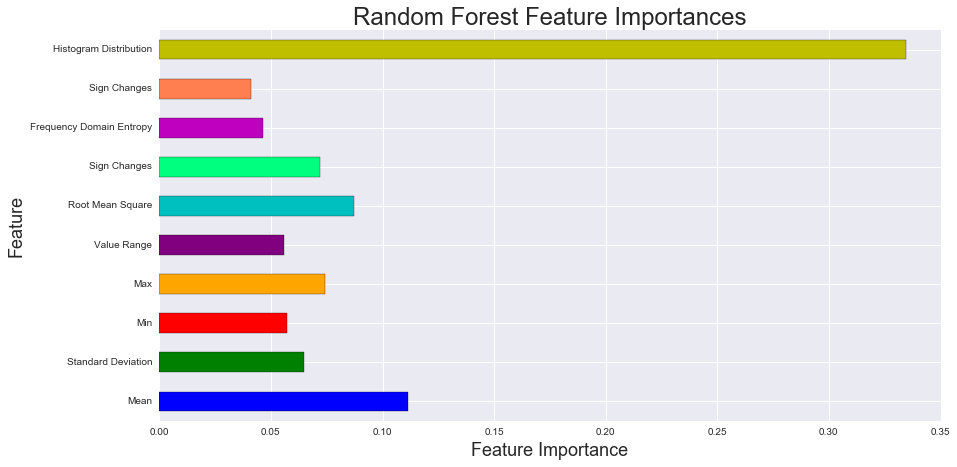

In [10]:
person_model(train, test, find_tree_nums=False)

In [11]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1).fit(train_f, train_l)

In [12]:
pred_labels = rf.predict(test_f)

In [14]:
print accuracy_score(pred_labels, test_l.as_matrix())

1.0


In [16]:
print pred_labels

[ 53.  53.  53. ...,  94.  94.  94.]
